In [1]:
dataset <- "TAA"
merging_datasets <- c(dataset, "ISAC")
state <- "Trentino-Alto Adige"
match_dist <- 15000
new_dataset <- "TAA2"


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)

source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/write.R")
source("src/database/startup.R")
source("src/database/plot.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/merging/analysis.R")
source("src/merging/display.R")
source("src/merging/combining.R")
source("src/merging/tagging.R")
source("notebooks/integrazioni_regionali/procedure/common_steps.R")

conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, state, "state")


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



In [3]:
nat_meta <- query_checkpoint_meta("ISAC", "qc1", conns$data) |>
    mutate(user_code = str_to_upper(user_code) |> str_squish()) |>
    collect() |>
    st_md_to_sf() |>
    st_filter(state_boundaries |> st_buffer(dist = 1000), .predicate = st_within) |>
    st_drop_geometry() |>
    filter(!(state %in% c("Veneto", "Lombardia")))
ds_meta <- query_checkpoint_meta(dataset, "qc1", conns$data) |>
    mutate(user_code = str_to_upper(user_code) |> str_squish()) |>
    collect()

metadata <- bind_rows(ds_meta, nat_meta) |>
    arrange(dataset, sensor_key) |>
    mutate(key = row_number())
metadata_db <- copy_to(conns$data, metadata, "metas_tmp", overwrite = TRUE)

sensor_matches <- close_matches(metadata_db, match_dist, conns$stations)

data <- query_checkpoint_data(merging_datasets, "qc1", conns$data) |>
    filter(valid) |>
    inner_join(metadata_db |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key")) |>
    select(!c(starts_with("qc_"), valid)) |>
    compute()

var_matches <- series_matches(data, sensor_matches, metadata_db)


In [4]:
# analysis <- series_matches_analysis(var_matches, data, metadata_db, matches_offsets = c(-1L, 0L, 1L))
# analysis |> write_xlsx_analysis(file.path("notebooks", "integrazioni_regionali", "trentino", "raw_analysis.xlsx"))
analysis <- read_parquet(file.path("notebooks", "integrazioni_regionali", "trentino", "raw_analysis.parquet"))


In [5]:
source(str_glue("notebooks/integrazioni_regionali/trentino/procedures/match_taggers.R"))
tagged_analysis <- analysis |>
    tag_same_series() |>
    default_logic(require_all = FALSE) |>
    tag_manual()

write_xlsx_analysis(tagged_analysis, file.path("notebooks", "integrazioni_regionali", "trentino", "tagged_analysis.xlsx"), starts_with("user_code"), starts_with("tag_"))


In [6]:
gs <- series_groups(tagged_analysis, metadata, data, tag_same_series)
ranked_series_groups <- rank_series_groups(
    gs$table,
    metadata |> mutate(network_prio = if_else(network == "ISAC", 2L, 1L)),
    c("TAA", "ISAC"),
    desc(network_prio), desc(dataset), desc(sensor_last)
)
ignore_corrections <- make_exclusion_table(tagged_analysis, NULL, network_x == "ISAC" | network_y == "ISAC")
incomp <- incompatible_merges(data, ranked_series_groups, tagged_analysis, 3L, 0.5, ignore_corrections)


In [9]:
i <- incomp |>
    left_join(metadata |> select(key, name, network, sensor_key), by = c("key_x" = "key")) |>
    left_join(metadata |> select(key, name, network, sensor_key), by = c("key_y" = "key"), suffix = c("_x", "_y")) |>
    arrange(desc(abs(k0 + 2 * k1 / pi)))
i


pkey,k0,k1,k2,k3,gkey,key_x,key_y,variable,offset_days,name_x,network_x,sensor_key_x,name_y,network_y,sensor_key_y
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>
282,0.8562092,0.00000000,0.000000000,0.000000000,141,569,220,1,0,Ragoli (Rifugio Alimonta),meteotrentino,225,RAGOLI_RIFUGIO_ALIMONTA,DPC,3619
17,0.6798449,0.19823864,0.021518795,0.232059529,28,517,57,-1,0,Male',meteotrentino,169,MALE,DPC,1678
220,0.5350677,0.38216575,0.004826798,0.034594324,110,513,186,1,0,Lases (frana),meteotrentino,164,LASES_FRANA,DPC,3583
326,1.1411448,-0.65574801,0.137460552,0.133396426,163,605,245,1,0,Val D'Ambiez,meteotrentino,269,VAL_D_AMBIEZ,DPC,3647
240,0.8479918,-0.23633099,0.207040937,0.017814709,120,532,198,1,0,Monte Groste' (Rifugio Graffer),meteotrentino,185,MONTE_GROST_RIFUGIO_GRAFFER,DPC,3596
12,0.1423507,0.86250877,0.144216633,0.005819207,6,10,11,1,0,BRESSANONE,DPC,425,BRESSANONE_MTX,DPC,426
11,-0.8385294,0.41394976,0.135137057,0.202554490,6,10,11,-1,0,BRESSANONE,DPC,425,BRESSANONE_MTX,DPC,426
242,0.4254398,0.22259162,0.044181086,-0.016828785,121,533,199,1,0,Monte Ruioch (Rifugio Tonini),meteotrentino,186,MONTE_RUIOCH_RIFUGIO_TONINI,DPC,3597
336,0.3885910,0.24771247,0.296024480,-0.081292729,168,616,250,1,0,Vermiglio (Capanna Presena),meteotrentino,280,VERMIGLIO_CAPANNA_PRESENA,DPC,3652


In [19]:
merge_results <- dynamic_merge(data, ranked_series_groups, metadata, tagged_analysis, rejection_threshold = 10, ignore_corrections, contribution_threshold = 2L*365L)
merged_checkpoint(merge_results, metadata, new_dataset, conns$stations)
# rm(merge_results)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2393880,127.9,5033440,268.9,NA,5033440,268.9
Vcells,57632448,439.8,159695896,1218.4,16384,166255194,1268.5


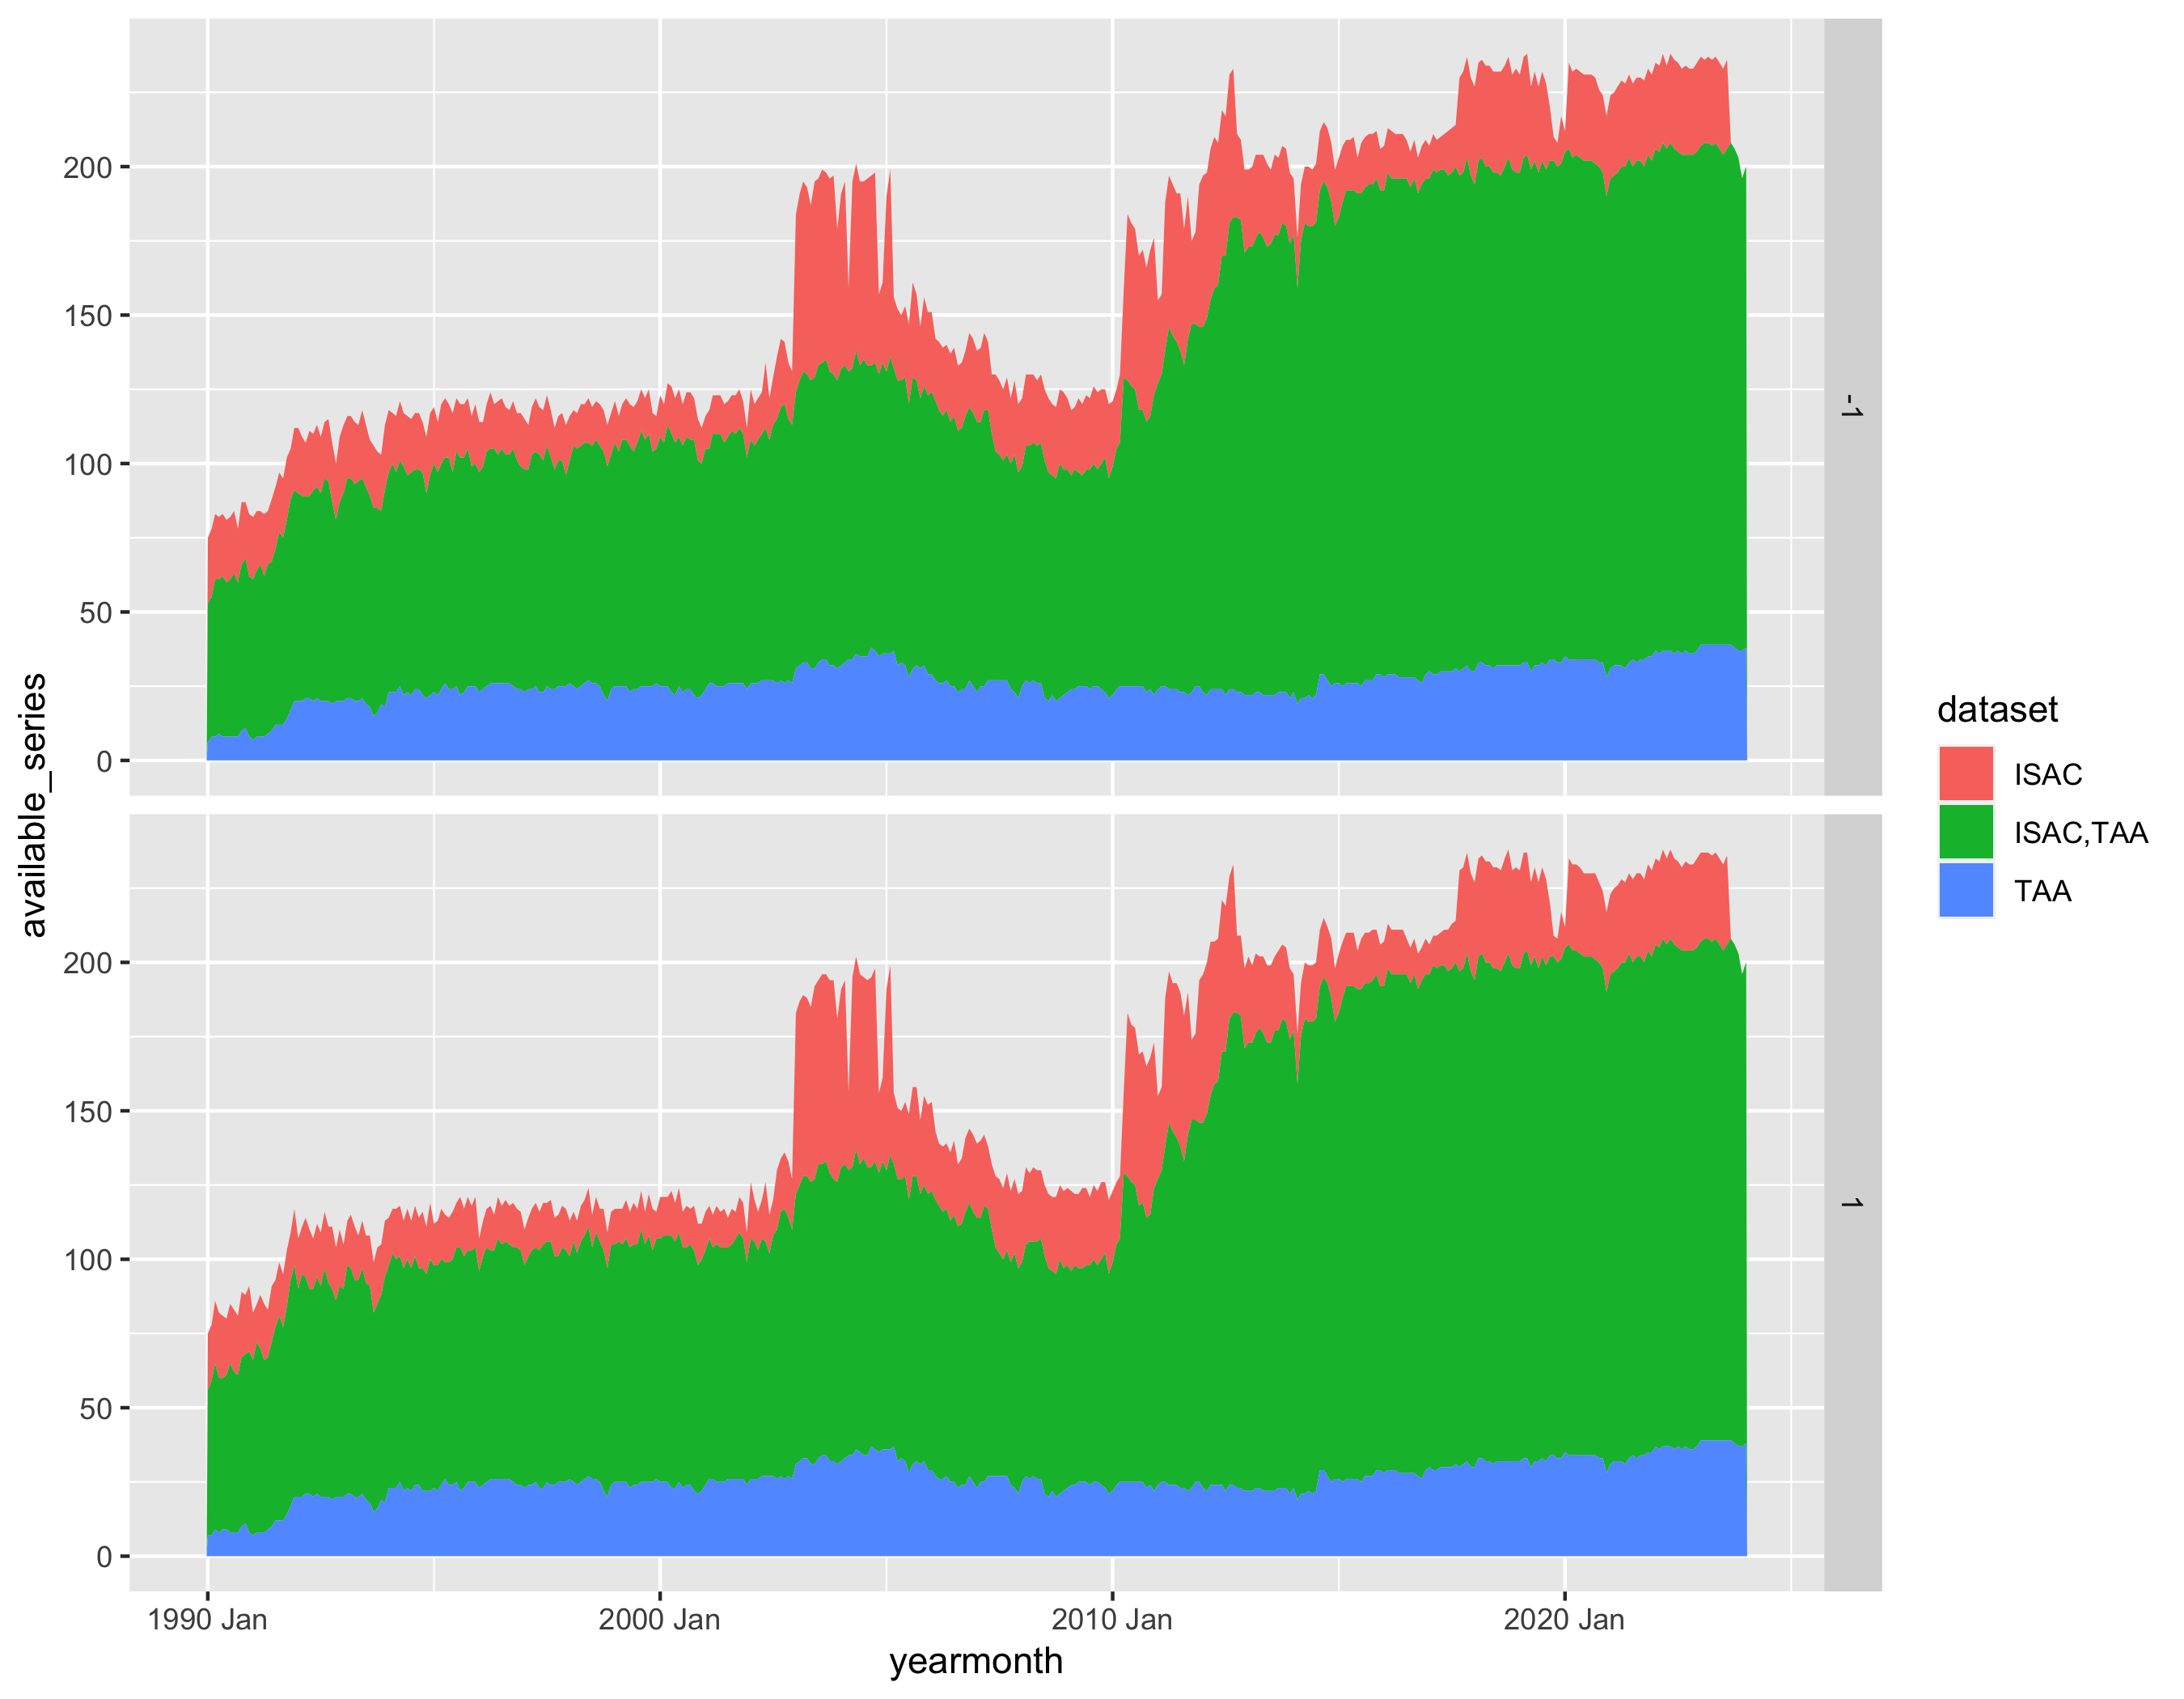

In [20]:
db <- query_checkpoint(new_dataset, "merged", conns$data, all_stations = FALSE)
mt <- db$meta |>
    select(sensor_key, from_datasets) |>
    collect() |>
    rowwise() |>
    mutate(dataset = paste0(from_datasets |> unique() |> sort(), collapse = ",")) |>
    ungroup() |>
    select(-from_datasets)
dt <- db$data |>
    select(-dataset) |>
    left_join(mt, by = "sensor_key", copy = TRUE) |>
    filter(year(date) >= 1990L)
pd <- ymonthly_availabilities(dt, stack = TRUE)
pd$plot + facet_grid(variable ~ .)


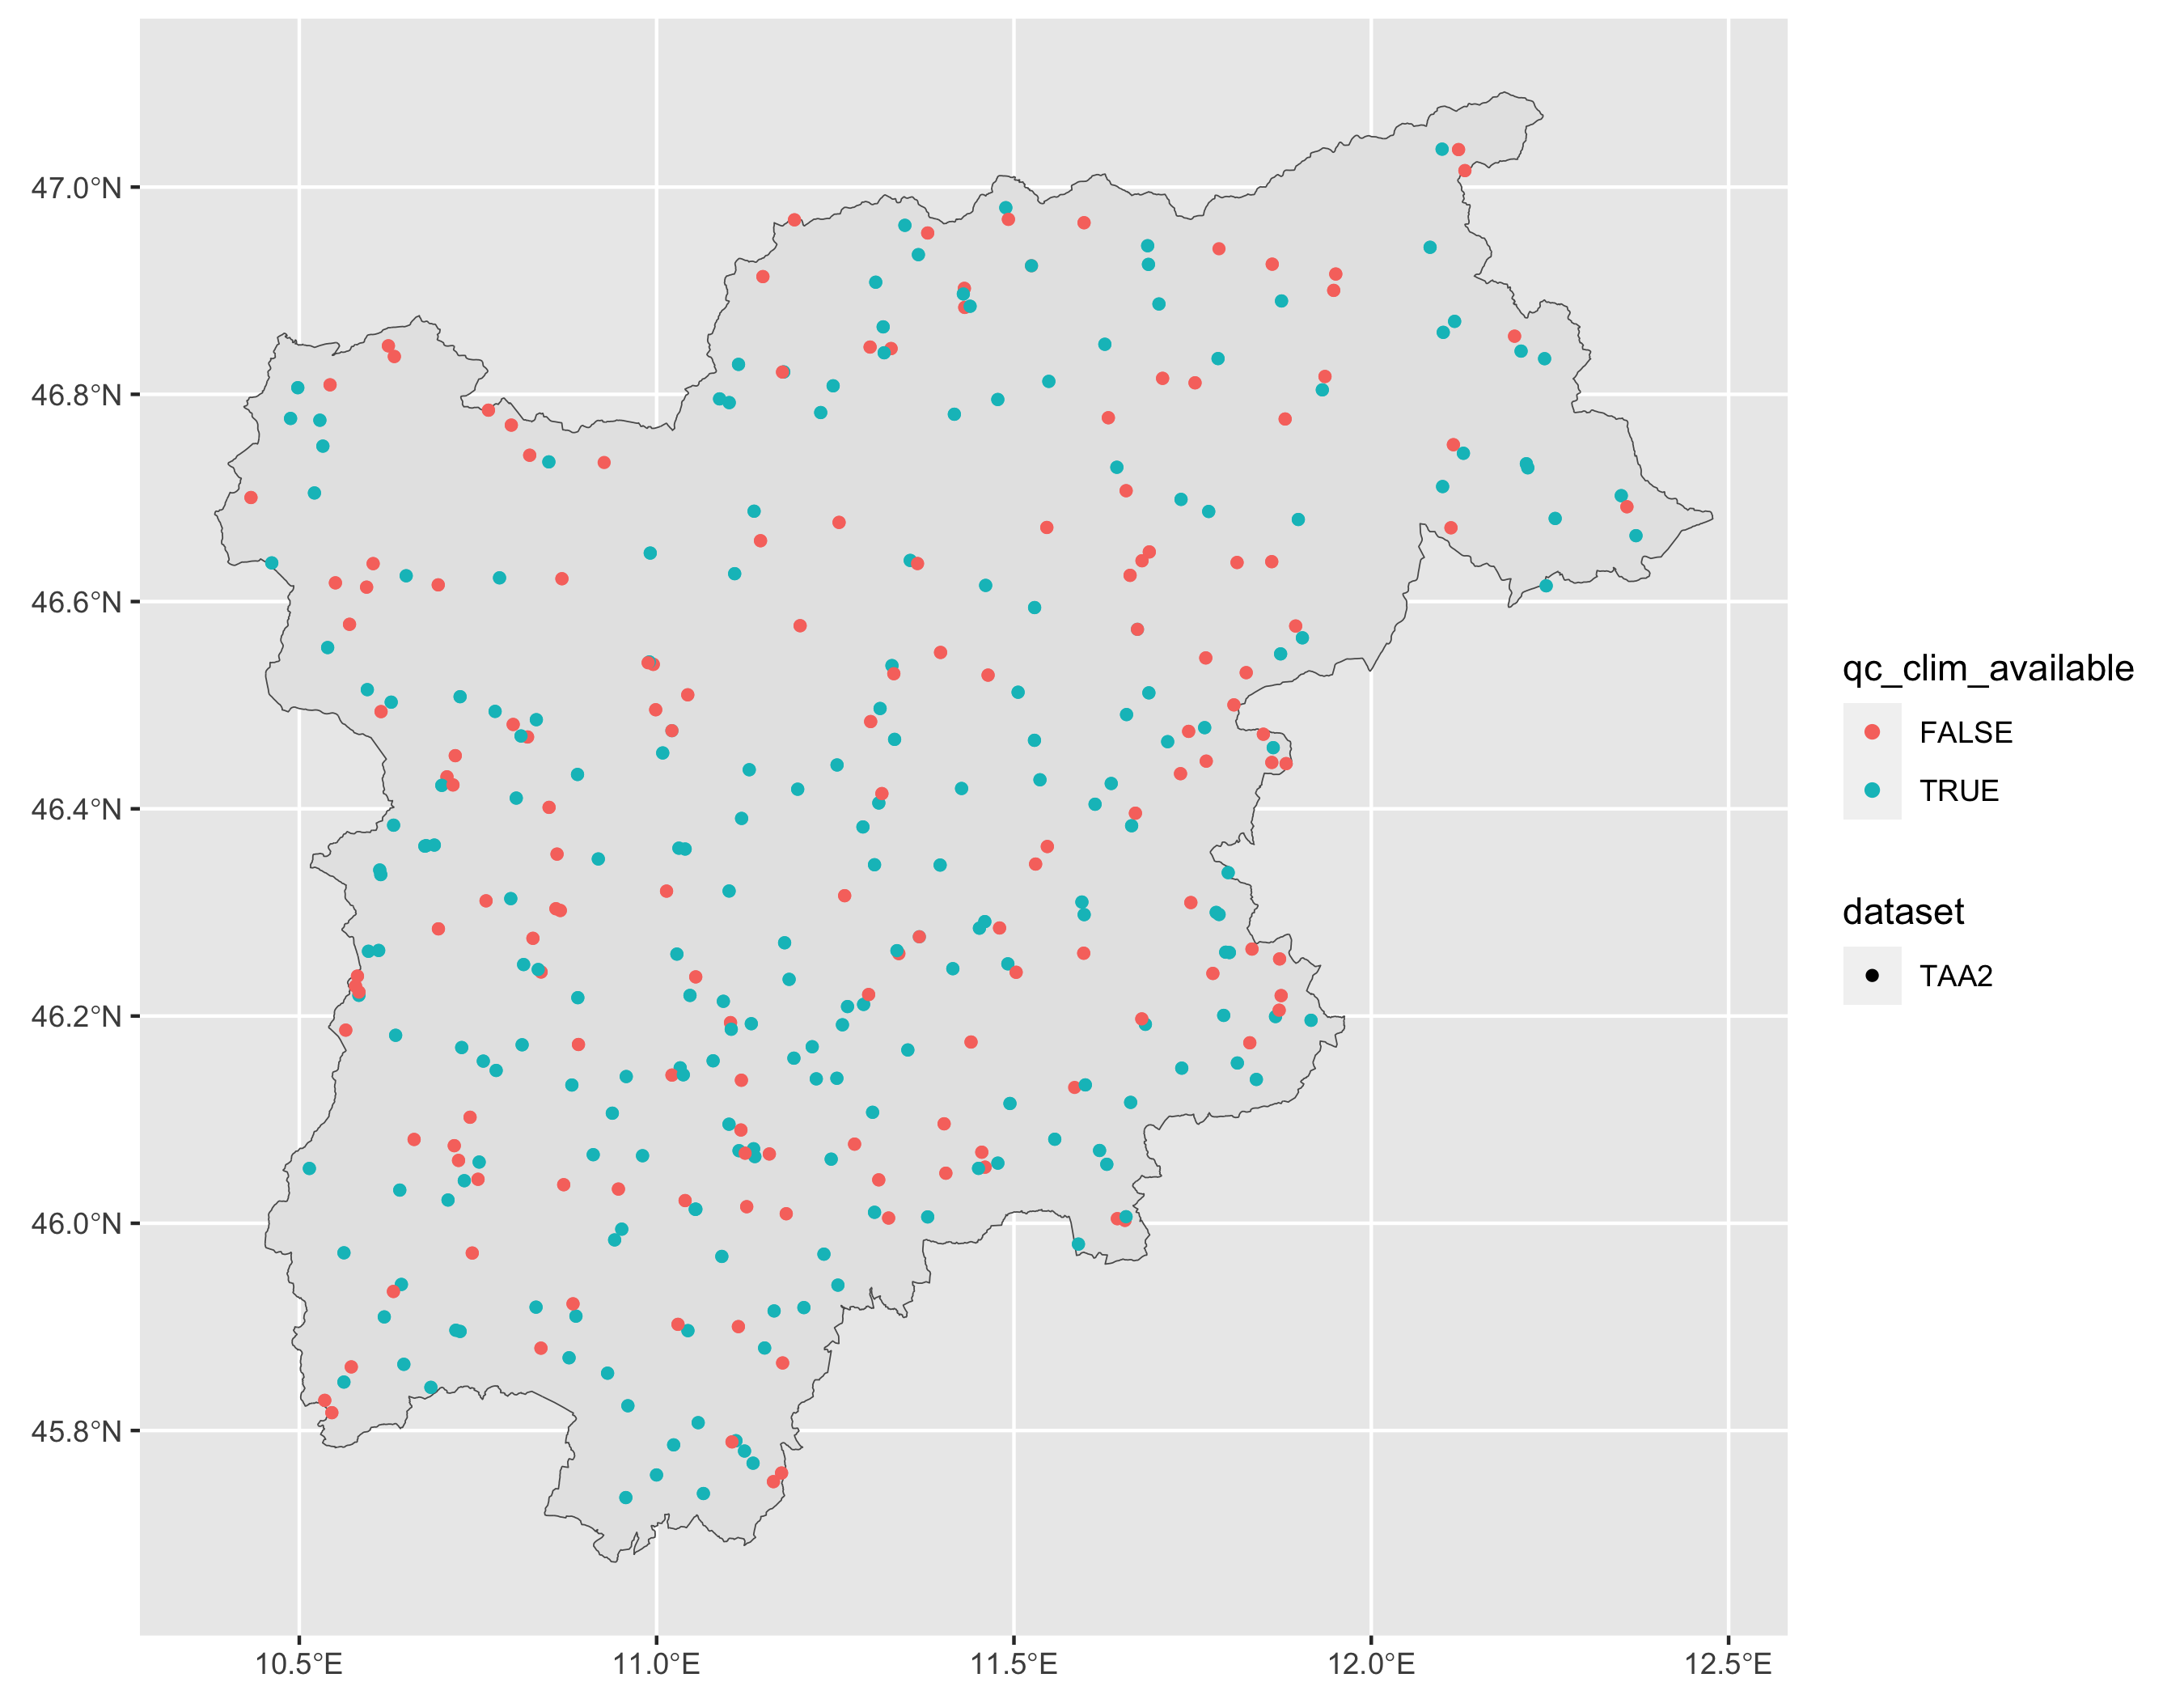

In [21]:
pd <- spatial_availabilities(pd$data |> mutate(dataset = new_dataset), db$meta, state_boundaries, n_years_threshold = 10L)
pd$plot


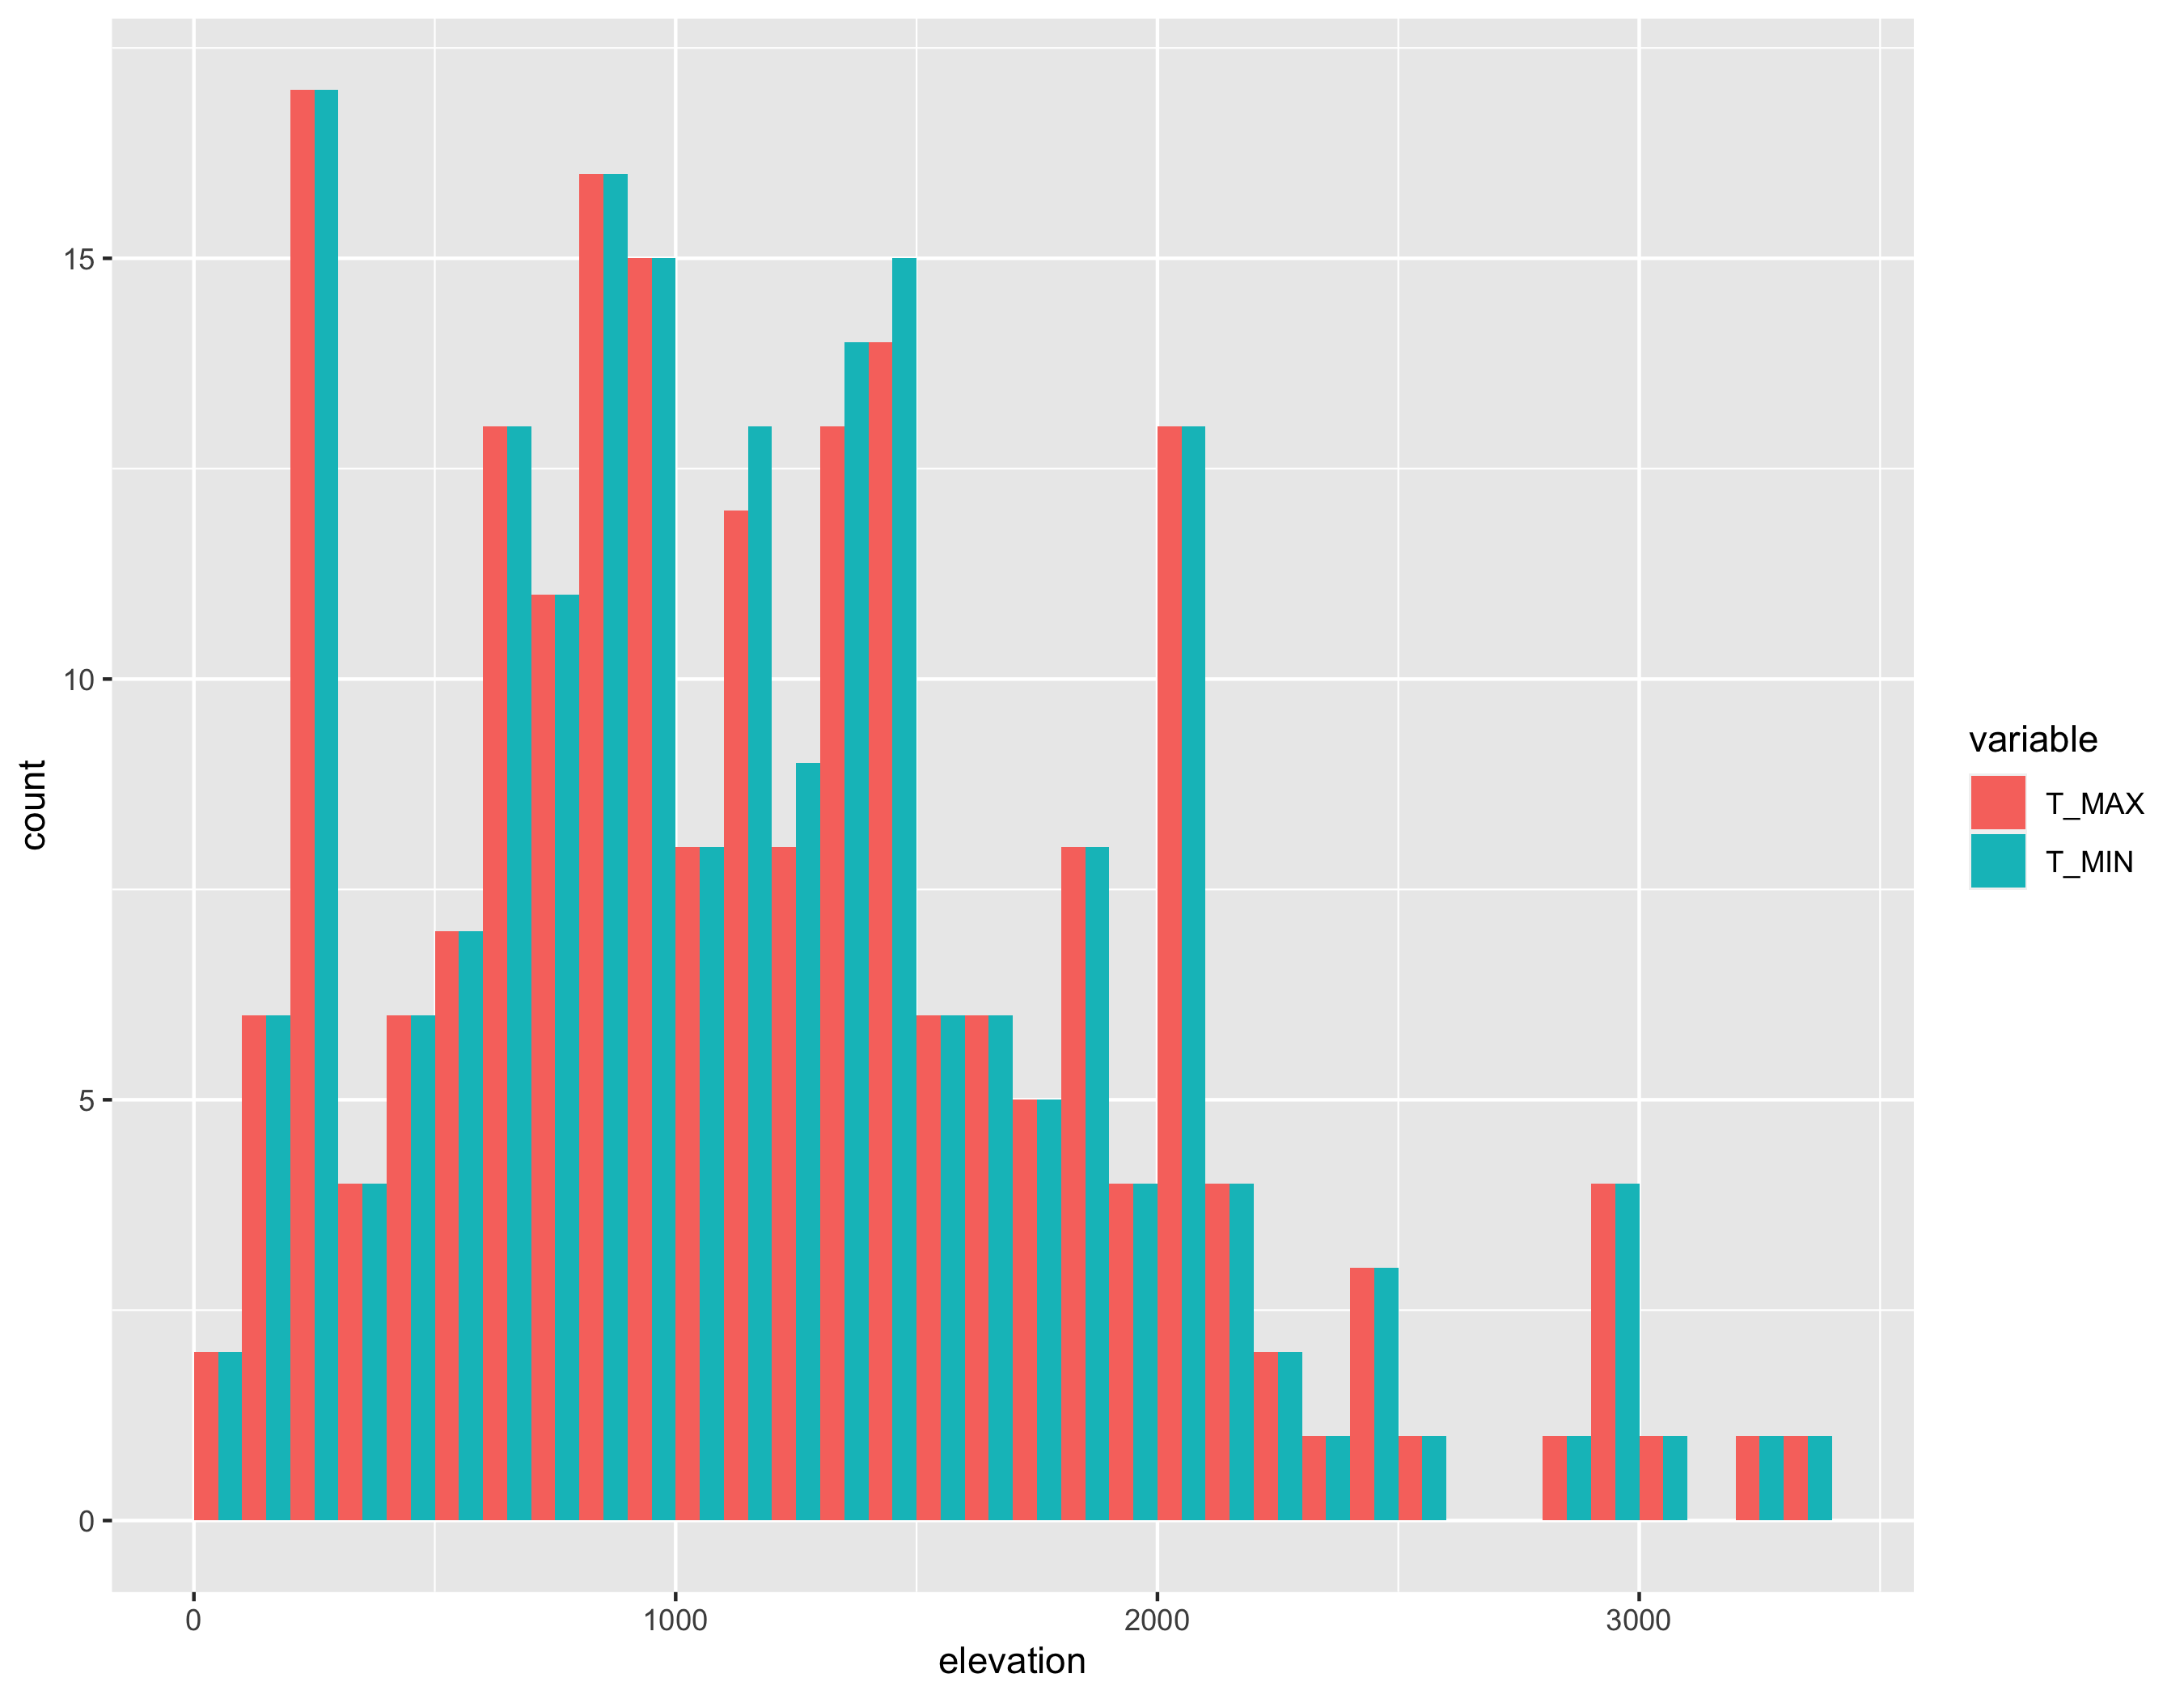

In [22]:
clim_availabilities <- pd$data |> mutate(dataset = new_dataset)
plot_available_by_elevation(clim_availabilities, db$meta |> collect())


In [48]:
db$meta |>
    collect() |>
    rowwise() |>
    mutate(from_datasets = str_flatten_comma(from_datasets), from_sensor_keys = str_flatten_comma(from_sensor_keys)) |>
    filter(valid90 > 0) |>
    st_md_to_sf() |>
    write_sf("taa.kml")
